# 事前準備：共通コードの実行
* このノートブックに接続したら，まずは以下の2つの共通コード（コードAとコードB）を実行する
* これらの共通コードを実行しないと，それ以降のコードが実行できないので注意する
* また，コードAとコードBは，ノートブックに接続するたび毎回実行すること（ノートブックに接続中は，何度も実行する必要はない）
* 共通コードの詳細についての説明は割愛する（簡単な説明は第2回の「[サンプルノートブック02](https://colab.research.google.com/github/yoshida-nu/lec_datascience/blob/main/doc/datascience_notebook02.ipynb)」を参照）

In [ ]:
# コードA：日本語化ライブラリ導入
! pip install japanize-matplotlib | tail -n 1

In [2]:
# コードB：共通事前処理

# B1:余分なワーニングを非表示にする
import warnings
warnings.filterwarnings('ignore')

# 必要ライブラリのimport
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib # matplotlib日本語化対応
import seaborn as sns

# B2:データフレーム表示用関数
from IPython.display import display

# B3:表示オプション調整
np.set_printoptions(suppress = True, precision = 3) #numpyの浮動小数点の表示精度
pd.options.display.float_format = '{:.3f}'.format #pandasでの浮動小数点の表示精度
pd.set_option('display.max_columns', None) #データフレームですべての列データを表示

# B4:グラフのデフォルトフォント指定
plt.rcParams['font.size'] = 14

# 乱数の種
random_seed = 0

# 顧客データのクラスタリング

## 用いるデータと分析の目的
* 例として，以下のURLにあるcsvファイルを用いる
>* https://tinyurl.com/2539almp
>* 出典: 須藤秋良, 株式会社フレアリンク: スッキリわかるPythonによる機械学習入門, インプレス, 2020
* ここで利用するデータは出典（教科書）のデータを加工している
* オリジナルのデータは，「Wholedf customers Data Set (卸売業者の顧客データ)」と呼ばれているデータセットで，ポルトガルの卸売業者の顧客データで，商品カテゴリ毎に顧客単位の年間支出額が入っている
>* オリジナルのデータのURL: https://archive.ics.uci.edu/ml/datasets/Wholedf+customers
* 以降，用いるデータのことを「顧客データ」と呼ぶ
* 今回は，k-means法を使って，顧客データをクラスタリングすることを考える

### データの読み込み
* 顧客データを読み込んで，内容を確認する
* 各列名と意味は以下のとおり
  
|**列名**| **意味** |
|:--|:--|
|生鮮食品| 生鮮食品の年間支出額 |
|乳製品| 乳製品の年間支出額 |
|食料雑貨品| 食料雑貨品の年間支出額 |
|冷凍食品| 冷凍食品の年間支出額 |
|洗剤・紙製品| 洗剤と紙製品の年間支出額 |
|惣菜| 惣菜の年間支出額 |
  
**［以下のコードの処理内容］**
* 1行目: ファイルのURLを変数`url`に代入
* 2行目: pandasの`read_csv`関数を使って，ファイルをDataFrameとして読み込んで，変数`df`に代入
* 3行目: `display`関数を使ってデータ（`df`の内容）を表示

In [4]:
url = 'https://tinyurl.com/2539almp'
df = pd.read_csv(url)
display(df)

,生鮮食品,乳製品,食料雑貨品,冷凍食品,洗剤・紙製品,惣菜
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185
...,...,...,...,...,...,...
435,29703,12051,16027,13135,182,2204
436,39228,1431,764,4510,93,2346
437,14531,15488,30243,437,14841,1867
438,10290,1981,2232,1038,168,2125


### 各特徴量の統計量
* 以下のコードで，読み込んだデータの各特徴量（生鮮食品～惣菜）の基本的な統計量を確認する
* 実行結果から，特徴量によって算術平均や標準偏差（ばらつき）が大きく異なっていることがわかる
  
**［以下のコードの処理内容］**
* 1～2行目: csvファイルをDataFrameとして読み込んで，変数`df`に代入
* 3行目: `describe`メソッドで`df`の基本的な統計量を計算し，その結果を`display`関数を使って表示

In [5]:
url = 'https://tinyurl.com/2539almp'
df = pd.read_csv(url)
display(df.describe())

,生鮮食品,乳製品,食料雑貨品,冷凍食品,洗剤・紙製品,惣菜
count,440.000,440.000,440.000,440.000,440.000,440.000
mean,12000.298,5796.266,7951.277,3071.932,2881.493,1524.870
std,12647.329,7380.377,9503.163,4854.673,4767.854,2820.106
min,3.000,55.000,3.000,25.000,3.000,3.000
25%,3127.750,1533.000,2153.000,742.250,256.750,408.250
50%,8504.000,3627.000,4755.500,1526.000,816.500,965.500
75%,16933.750,7190.250,10655.750,3554.250,3922.000,1820.250
max,112151.000,73498.000,92780.000,60869.000,40827.000,47943.000


## データの前処理
* 教師なし学習では，正解データを使ってモデルの性能を評価することができない
* そのため，訓練データとテストデータに分割する必要はないことに注意しておく

### 欠損値の確認
* 以下のコードで，データに欠損値がないか確認する
* 実行結果から，顧客データには欠損値がないことがわかる
  
**［以下のコードの処理内容］**
* 1～2行目: csvファイルをDataFrameとして読み込んで，変数`df`に代入
* 3行目: `isnull`メソッドと`sum`メソッドを組み合わせて，各列の欠損値の数を計算して，`display`関数で表示する

In [6]:
url = 'https://tinyurl.com/2539almp'
df = pd.read_csv(url)
display(pd.DataFrame(df.isnull().sum(), columns = ['欠損値の数']))

,欠損値の数
生鮮食品,0
乳製品,0
食料雑貨品,0
冷凍食品,0
洗剤・紙製品,0
惣菜,0


### データの標準化
* 線形回帰モデルやロジスティック回帰モデルと同様に，クラスタリング（k-means法）においても，データの標準化を行う
  
**［以下のコードの処理内容］**
* 1～2行目: csvファイルをDataFrameとして読み込んで，変数`df`に代入
* 3行目: `preprocessing`モジュールの`StandardScaler`クラスの読み込み
* 4行目: `StandardScaler`クラスのオブジェクトを生成し，変数`sc`に代入
* 5行目: `sc`に対し，`fit`メソッドを適用する（引数は`df`）
* 6行目: `sc`に対する`transform`メソッドで`df`を標準化し，その結果を変数`df_s`に代入
* 7行目: `DataFrame`関数で，`df_s`をDataFrameに変換し，その結果を変数`df_cluster`に代入
>* `columns = df.columns`で，変換したDataFrameの列名を「生鮮食品」～「惣菜」に指定
* 8行目: `display`関数を使ってデータ（`df_cluster`の内容）を表示

In [42]:
url = 'https://tinyurl.com/2539almp'
df = pd.read_csv(url)
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(df)
df_s = sc.transform(df)
df_cluster = pd.DataFrame(df_s, columns = df.columns)
display(df_cluster)

,生鮮食品,乳製品,食料雑貨品,冷凍食品,洗剤・紙製品,惣菜
0,0.053,0.524,-0.041,-0.589,-0.044,-0.066
1,-0.391,0.544,0.170,-0.270,0.086,0.089
2,-0.447,0.409,-0.028,-0.138,0.133,2.243
3,0.100,-0.624,-0.393,0.687,-0.499,0.093
4,0.840,-0.052,-0.079,0.174,-0.232,1.299
...,...,...,...,...,...,...
435,1.401,0.848,0.851,2.075,-0.567,0.241
436,2.155,-0.592,-0.757,0.297,-0.586,0.292
437,0.200,1.315,2.348,-0.543,2.511,0.121
438,-0.135,-0.518,-0.603,-0.419,-0.570,0.213


## モデルの学習（k-means法によるクラスタリング）
* k-means法によるクラスタリングは，`sklearn`（scikit-learn）の`cluster`モジュールにおける`KMeans`クラスを使う
* k-means法によるクラスタリングの流れ:
>* `LKMeans`クラスを読み込む（インポートする）
>* インポートの書式: `from sklearn.cluster import KMeans`
>* `KMeans`クラスのオブジェクトを生成し，変数に代入する
>* オブジェクト生成の書式: `変数 = KMeans(n_clusters = [クラスタ数], random_state = [乱数の種])`
>* 乱数は初期値（重心）を決める際に使用する（乱数によって結果が変わることに注意する）
>* モデルを学習する（クラスタリングを行う）
>* モデルの学習の書式: `変数.fit(データ)`
* クラスタリングした結果（クラスタ番号）は，オブジェクトの`labels_`属性から確認できる
>* 書式: `変数.labels_`
  
**［以下のコードの処理内容］**
* 1～2行目: csvファイルをDataFrameとして読み込んで，変数`df`に代入
* 3～7行目: データの標準化を行い，標準化したデータを変数`df_cluster`に代入
* 8行目:  `sklearn` (scikit-learn) の`cluster`モジュール内にある`KMeans`クラスを読み込む 
* 9行目: `KMeans(n_clusters = 3, random_state = random_seed)`で，モデルの学習を行うためのオブジェクトを`KMeans`クラスから生成し，変数`kmeans_model`に代入
>* `n_clusters = 3`で，クラスタ数を 3 に設定
>* `random_state = random_seed`で，乱数を固定
* 10行目: `fit`メソッドでモデルの学習（データ`df_cluster`のクラスタリング）を実行
* 11行目: クラスタリングした結果の列データ（`kmeans_model.labels_`）を`df_cluster`に追加
>* 列名を「cluster」とした
* 12行目: `display`関数を使ってデータ（`df`の内容）を表示

In [46]:
url = 'https://tinyurl.com/2539almp'
df = pd.read_csv(url)
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(df)
df_s = sc.transform(df)
df_cluster = pd.DataFrame(df_s, columns = df.columns)
from sklearn.cluster import KMeans
kmeans_model = KMeans(n_clusters = 3, random_state = random_seed)
kmeans_model.fit(df_cluster)
df_cluster['cluster'] = kmeans_model.labels_
display(df_cluster)

,生鮮食品,乳製品,食料雑貨品,冷凍食品,洗剤・紙製品,惣菜,cluster
0,0.053,0.524,-0.041,-0.589,-0.044,-0.066,2
1,-0.391,0.544,0.170,-0.270,0.086,0.089,2
2,-0.447,0.409,-0.028,-0.138,0.133,2.243,2
3,0.100,-0.624,-0.393,0.687,-0.499,0.093,2
4,0.840,-0.052,-0.079,0.174,-0.232,1.299,0
...,...,...,...,...,...,...,...
435,1.401,0.848,0.851,2.075,-0.567,0.241,0
436,2.155,-0.592,-0.757,0.297,-0.586,0.292,0
437,0.200,1.315,2.348,-0.543,2.511,0.121,1
438,-0.135,-0.518,-0.603,-0.419,-0.570,0.213,2


## モデルの分析
* クラスタリングができたので，各クラスタに属するデータの特徴などを分析する

### 各クラスタのデータ数
* `value_counts`メソッドを使って，各クラスタのデータ数を確認する
* `value_counts`メソッドについては，第3回「[サンプルノートブック03](https://colab.research.google.com/github/yoshida-nu/lec_datascience/blob/main/doc/datascience_notebook03.ipynb)」や共通資料「[ノートブック：SeriesとDataFrameの基本操作](https://colab.research.google.com/github/yoshida-nu/lec_datascience/blob/main/doc/datascience_notebook_se_df.ipynb)」を参照
  
**［以下のコードの処理内容］**
* 1～2行目: csvファイルをDataFrameとして読み込んで，変数`df`に代入
* 3～7行目: データの標準化を行い，標準化したデータを変数`df_cluster`に代入
* 8～11行目: データのクラスタリングを行い，その結果を`df_cluster`に代入
* 12行目: クラスタリングの結果が格納されている cluster列の値の頻度を抽出し，その結果を`display`関数で表示

In [45]:
url = 'https://tinyurl.com/2539almp'
df = pd.read_csv(url)
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(df)
df_s = sc.transform(df)
df_cluster = pd.DataFrame(df_s, columns = df.columns)
from sklearn.cluster import KMeans
kmeans_model = KMeans(n_clusters = 3, random_state = random_seed)
kmeans_model.fit(df_cluster)
df_cluster['cluster'] = kmeans_model.labels_
display(pd.DataFrame(df_cluster['cluster'].value_counts()))

,count
cluster,
2,322
0,72
1,46


## 各クラスタにおける特徴量の算術平均
* `groupby`メソッドと算術平均を計算する`mean`メソッドを使って，各クラスタにおける特徴量の算術平均を計算する
* `groupby`メソッドについては，第5回「[サンプルノートブック05](https://colab.research.google.com/github/yoshida-nu/lec_datascience/blob/main/doc/datascience_notebook05.ipynb)」や共通資料「[ノートブック：SeriesとDataFrameの基本操作](https://colab.research.google.com/github/yoshida-nu/lec_datascience/blob/main/doc/datascience_notebook_se_df.ipynb)」を参照
  
**［以下のコードの処理内容］**
* 1～2行目: csvファイルをDataFrameとして読み込んで，変数`df`に代入
* 3～7行目: データの標準化を行い，標準化したデータを変数`df_cluster`に代入
* 8～11行目: データのクラスタリングを行い，その結果を`df_cluster`に代入
* 12行目: 各クラスタにおける各特徴量の算術平均を変数`cluster_mean`に代入
>* 算術平均は`mean`メソッドを用いて計算 ⇒ `df_cluster.groupby('cluster').mean()`
* 13行目: `DataFrame`関数で`cluster_mean`をDataFrameに変換し，その結果を`display`関数で表示
>* `groupby`メソッドによる集計結果はSeriesとなる

In [47]:
url = 'https://tinyurl.com/2539almp'
df = pd.read_csv(url)
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(df)
df_s = sc.transform(df)
df_cluster = pd.DataFrame(df_s, columns = df.columns)
from sklearn.cluster import KMeans
kmeans_model = KMeans(n_clusters = 3, random_state = random_seed)
kmeans_model.fit(df_cluster)
df_cluster['cluster'] = kmeans_model.labels_
cluster_mean = df_cluster.groupby('cluster').mean()
display(pd.DataFrame(cluster_mean))

,生鮮食品,乳製品,食料雑貨品,冷凍食品,洗剤・紙製品,惣菜
cluster,,,,,,
0,1.523,-0.137,-0.246,1.039,-0.409,0.305
1,-0.243,1.944,2.138,-0.042,2.077,0.646
2,-0.306,-0.247,-0.251,-0.226,-0.205,-0.161


### 各特徴量の算術平均の可視化
* 各クラスタの算術平均を棒グラフで可視化する
* 棒グラフは，DataFrameの`plot`メソッドを使って作成する
* `plot`メソッドについては，共通資料「[ノートブック：SeriesとDataFrameの基本操作](https://colab.research.google.com/github/yoshida-nu/lec_datascience/blob/main/doc/datascience_notebook_se_df.ipynb)」を参照
  
**［以下のコードの処理内容］**
* 1～2行目: csvファイルをDataFrameとして読み込んで，変数`df`に代入
* 3～7行目: データの標準化を行い，標準化したデータを変数`df_cluster`に代入
* 8～11行目: データのクラスタリングを行い，その結果を`df_cluster`に代入
* 12行目: 各クラスタにおける各特徴量の算術平均を変数`cluster_mean`に代入
>* 算術平均は`mean`メソッドを用いて計算 ⇒ `df_cluster.groupby('cluster').mean()`
* 13行目: `plot`メソッドを使って，各クラスタの算術平均`cluster_mean`の棒グラフを作成
>* `kind = 'bar'`で，グラフの種類を棒グラフに設定
>* `title = '各クラスタの算術平均'`で，グラフのタイトルを「各クラスタの算術平均」に設定
* 14行目: `show`関数で，それまでに設定したグラフを実行画面に表示

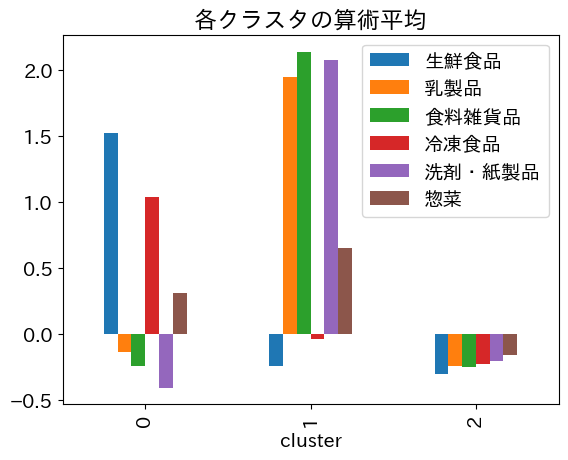

In [48]:
url = 'https://tinyurl.com/2539almp'
df = pd.read_csv(url)
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(df)
df_s = sc.transform(df)
df_cluster = pd.DataFrame(df_s, columns = df.columns)
from sklearn.cluster import KMeans
kmeans_model = KMeans(n_clusters = 3, random_state = random_seed)
kmeans_model.fit(df_cluster)
df_cluster['cluster'] = kmeans_model.labels_
cluster_mean = df_cluster.groupby('cluster').mean()
cluster_mean.plot(kind = 'bar', title = '各クラスタの算術平均')
plt.show()

# エルボー法によるクラスタ数の決定
* k-means法では分析者が事前に何個のクラスタに分けるかを決定する必要がある
* クラスタ数の決め方の一つにエルボー法がある
* エルボー法の手順
>* クラスタ数を事前に見積もる方法の1つ
>* クラスタ数kを変化させたときの，クラスタ内誤差平方和（SSE: Sum of Squared Errors）の減少度合をみて適切なkを決める
>* SSE: 各クラスタの重心点（平均）とそのクラスタに属するデータの差（距離）の2乗の総和 ⇒ kが増加するとSSEは減少する
>* SSEの減少度合が大きく低下している k をクラスタ数とする
* 以下のコードで，クラスタ数2～30のSSEを計算し，その結果をグラフ化している
* コードの内容は理解しなくてよいので，実行結果だけ確認しておく

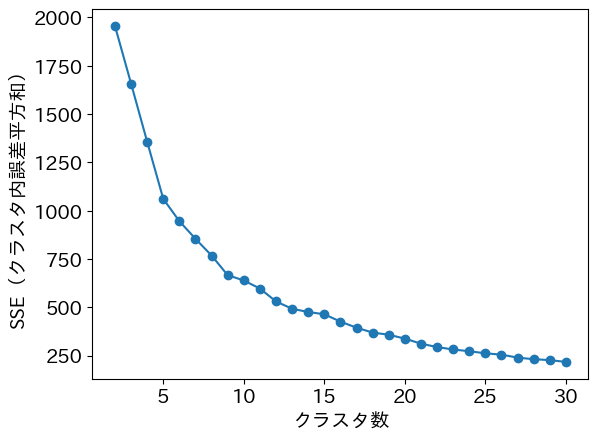

In [ ]:
url = 'https://tinyurl.com/2539almp'
df = pd.read_csv(url)
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(df)
df_s = sc.transform(df)
df_cluster = pd.DataFrame(df_s, columns = df.columns)
from sklearn.cluster import KMeans
sse_list = []
for n in range(2, 31):
    kmeans_model = KMeans(n_clusters = n, random_state = random_seed)
    kmeans_model.fit(df_cluster)
    sse_list.append(kmeans_model.inertia_)
plt.plot(range(2,31), sse_list, marker = 'o')
plt.xlabel('クラスタ数')
plt.ylabel('SSE（クラスタ内誤差平方和）')
plt.show()

# アヤメデータのクラスタリング

## 用いるデータと分析の目的
* 例として，第3回と第4回で使用した以下のURLにあるアヤメデータのcsvファイルを用いる
>* https://bit.ly/43mPz0L
* アヤメデータの2つの特徴量「花弁長さ」と「花弁幅」からなるデータのクラスタリングを行う

## データの前処理
* 以下のコードで，アヤメデータの前処理を行う
* 前処理の内容
>* 欠損値を各特徴量の算術平均でそれぞれ置き換える
>* 「花弁長さ」と「花弁幅」のデータを抽出
>* データの標準化を行う
  
**［以下のコードの処理内容］**
* 1行目: ファイルのURLを変数`url`に代入
* 2行目: pandasの`read_csv`関数を使って，ファイルをDataFrameとして読み込んで，変数`df`に代入
* 3行目: `fillna`メソッドを使って，`df.fillna(df[['がく片長さ','がく片幅', '花弁長さ', '花弁幅']].mean())`とし，欠損値を各説明変数の算術平均にそれぞれ置き換えて変数`df`に代入
* 4行目: データの列名を要素とするリスト`['花弁長さ', '花弁幅']`を変数`cols`に代入
* 5行目: DataFrame `df` から,`df[cols]`で，データの列だけ取り出し変数`df_cluster`に代入
* 6行目: `preprocessing`モジュールの`StandardScaler`クラスの読み込み
* 7行目: `StandardScaler`クラスのオブジェクトを生成し，変数`sc`に代入
* 8行目: `sc`に対し，`fit`メソッドを適用する（引数は`df_cluster`）
* 9行目: `sc`に対する`transform`メソッドで`df_cluster`を標準化し，その結果を変数`df_s`に代入
* 10行目: `DataFrame`関数で，`df_s`をDataFrameに変換し，その結果を変数`df_cluster`に代入
>* `columns = cols`で，変換したDataFrameの列名を「花弁長さ」と「花弁幅」（`cols`）に指定
* 11行目: `display`関数で，データ`df_cluster`の内容を表示

In [54]:
url = 'https://bit.ly/43mPz0L'
df = pd.read_csv(url)
df = df.fillna(df[['がく片長さ', 'がく片幅', '花弁長さ', '花弁幅']].mean())
cols = ['花弁長さ', '花弁幅']
df_cluster = df[cols]
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(df_cluster)
df_s = sc.transform(df_cluster)
df_cluster = pd.DataFrame(df_s, columns = cols)
display(df_cluster)

,花弁長さ,花弁幅
0,-1.773,-1.328
1,-0.596,-1.328
2,-1.555,-1.328
3,-0.988,-1.328
4,-0.204,-1.328
...,...,...
145,0.232,1.540
146,0.886,0.041
147,-0.000,1.116
148,0.624,1.540


## モデルの学習（k-means法によるクラスタリング）
**［以下のコードの処理内容］**
* 1～2行目: csvファイルをDataFrameとして読み込んで，変数`df`に代入
* 3行目: 欠損値への対処 ⇒ その結果を変数`df`に代入
* 4～5行目: `df` からデータの列`['花弁長さ', '花弁幅']`だけ取り出し変数`df_cluster`に代入
* 6～10行目: データの標準化を行い，標準化したデータを変数`df_cluster`に代入
* 11行目:  `sklearn` (scikit-learn) の`cluster`モジュール内にある`KMeans`クラスを読み込む 
* 12行目: `KMeans(n_clusters = 3, random_state = random_seed)`で，モデルの学習を行うためのオブジェクトを`KMeans`クラスから生成し，変数`kmeans_model`に代入
>* `n_clusters = 3`で，クラスタ数を 3 に設定
>* `random_state = random_seed`で，乱数を固定
* 13行目: `fit`メソッドでモデルの学習（データ`df_cluster`のクラスタリング）を実行
* 14行目: クラスタリングした結果の列データ（`kmeans_model.labels_`）を`df_cluster`に追加
>* 列名を「cluster」とした
* 15行目: `display`関数を使ってデータ（`df_cluster`の内容）を表示

In [55]:
url = 'https://bit.ly/43mPz0L'
df = pd.read_csv(url)
df = df.fillna(df[['がく片長さ', 'がく片幅', '花弁長さ', '花弁幅']].mean())
cols = ['花弁長さ', '花弁幅']
df_cluster = df[cols]
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(df_cluster)
df_s = sc.transform(df_cluster)
df_cluster = pd.DataFrame(df_s, columns = cols)
from sklearn.cluster import KMeans
kmeans_model = KMeans(n_clusters = 3, random_state = random_seed)
kmeans_model.fit(df_cluster)
df_cluster['cluster'] = kmeans_model.labels_
display(df_cluster)

,花弁長さ,花弁幅,cluster
0,-1.773,-1.328,1
1,-0.596,-1.328,1
2,-1.555,-1.328,1
3,-0.988,-1.328,1
4,-0.204,-1.328,1
...,...,...,...
145,0.232,1.540,2
146,0.886,0.041,0
147,-0.000,1.116,0
148,0.624,1.540,2


## 各クラスタのデータ数
**［以下のコードの処理内容］**
* 1～2行目: csvファイルをDataFrameとして読み込んで，変数`df`に代入
* 3行目: 欠損値への対処 ⇒ その結果を変数`df`に代入
* 4～5行目: `df` からデータの列`['花弁長さ', '花弁幅']`だけ取り出し変数`df_cluster`に代入
* 6～10行目: データの標準化を行い，標準化したデータを変数`df_cluster`に代入
* 11～14行目: データのクラスタリングを行い，その結果を`df_cluster`に代入
* 15行目: クラスタリングの結果が格納されている cluster列の値の頻度を抽出し，その結果を`display`関数で表示

In [56]:
url = 'https://bit.ly/43mPz0L'
df = pd.read_csv(url)
df = df.fillna(df[['がく片長さ', 'がく片幅', '花弁長さ', '花弁幅']].mean())
cols = ['花弁長さ', '花弁幅']
df_cluster = df[cols]
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(df_cluster)
df_s = sc.transform(df_cluster)
df_cluster = pd.DataFrame(df_s, columns = cols)
from sklearn.cluster import KMeans
kmeans_model = KMeans(n_clusters = 3, random_state = random_seed)
kmeans_model.fit(df_cluster)
df_cluster['cluster'] = kmeans_model.labels_
display(pd.DataFrame(df_cluster['cluster'].value_counts()))

,count
cluster,
1,56
0,51
2,43


## クラスタと種類のクロス集計
* クラスタリングによって分割された各クラスタのデータとアヤメの種類がどれくらい一致しているかを確認する
* 具体的には，クラスタと種類に対して，組み合わせ頻度を数えるクロス集計を行う
* 組み合わせ頻度を数えるクロス集計は，pandas（`pd`）の`crosstab`関数を用いる
* `crosstab`関数については，共通資料「[ノートブック：SeriesとDataFrameの基本操作](https://colab.research.google.com/github/yoshida-nu/lec_datascience/blob/main/doc/datascience_notebook_se_df.ipynb)」を参照
* 以下のコードで，組み合わせ頻度を数えるクロス集計を行った結果，setosa はクラスタ1，versicolor はクラスタ0，virginica はクラスタ2にそれぞれ分かれている傾向が見られる
* 特に setosa は完全に分離されていることがわかる
  
**［以下のコードの処理内容］**
* 1～2行目: csvファイルをDataFrameとして読み込んで，変数`df`に代入
* 3行目: 欠損値への対処 ⇒ その結果を変数`df`に代入
* 4～5行目: `df` からデータの列`['花弁長さ', '花弁幅']`だけ取り出し変数`df_cluster`に代入
* 6～10行目: データの標準化を行い，標準化したデータを変数`df_cluster`に代入
* 11～14行目: データのクラスタリングを行い，その結果を`df_cluster`に代入
* 15行目: `df_cluster`に種類の列 `df['種類']` を追加する
* 16行目: `crosstab`メソッドを使って，cluster列（`df_cluster['cluster']`）と種類列（`df_cluster['種類']`）の組み合わせ頻度を数えるクロス集計を行い，その結果（DataFrame）を変数`ct`に代入
* 17行目: `display`関数で，クロス集計の結果 `ct` を表示

In [60]:
url = 'https://bit.ly/43mPz0L'
df = pd.read_csv(url)
df = df.fillna(df[['がく片長さ', 'がく片幅', '花弁長さ', '花弁幅']].mean())
cols = ['花弁長さ', '花弁幅']
df_cluster = df[cols]
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(df_cluster)
df_s = sc.transform(df_cluster)
df_cluster = pd.DataFrame(df_s, columns = cols)
from sklearn.cluster import KMeans
kmeans_model = KMeans(n_clusters = 3, random_state = random_seed)
kmeans_model.fit(df_cluster)
df_cluster['cluster'] = kmeans_model.labels_
df_cluster['種類'] = df['種類']
ct = pd.crosstab(df_cluster['cluster'], df_cluster['種類'])
display(ct)

種類,setosa,versicolor,virginica
cluster,,,
0,0,37,14
1,50,6,0
2,0,7,36


## 散布図の作成
* クロス集計の結果を視覚的に確認するため，花弁長さと花弁幅に対する散布図を2つ作成する
>* 一方はクラスタごとにマーカーを色分けした散布図
>* もう一方は種類ごとにマーカーを色分けした散布図
* 散布図は，seaborn（`sns`）の`lmplot`関数を用いて作成する
* 書式: `sns.lmplot(data = [DataFrame], x = [x軸の列名], y = [y軸の列名], hue = [色分けしたい列名], fit_reg = False)`
>* `data`には，散布図を作成する対象のDataFrameを指定
>* `x`には，x軸に設定する列の列名
>* `y`には，y軸に設定する列の列名
>* `hue`には，色分けしたい列の列名
>* `fit_reg = False`で，回帰直線を非表示
>* `lmplot`関数は，散布図上に回帰直線を描くことができるが，ここでは必要ないので`fit_reg = False`とする
>* `fit_reg = True`（デフォルト）にすると，`hue`で指定した列の値ごとの回帰直線が表示される
  
**［以下のコードの処理内容］**
* 1～2行目: csvファイルをDataFrameとして読み込んで，変数`df`に代入
* 3行目: 欠損値への対処 ⇒ その結果を変数`df`に代入
* 4～5行目: `df` からデータの列`['花弁長さ', '花弁幅']`だけ取り出し変数`df_cluster`に代入
* 6～10行目: データの標準化を行い，標準化したデータを変数`df_cluster`に代入
* 11～14行目: データのクラスタリングを行い，その結果を`df_cluster`に代入
* 15行目: `df_cluster`に種類の列 `df['種類']` を追加する
* 16行目: `lmplot`関数を使って，クラスタごとに色分けした散布図を作成
* 17行目: `show`関数で，それまでに設定した図（クラスタごとに色分けした散布図）を実行画面に表示
* 18行目: `lmplot`関数を使って，種類ごとに色分けした散布図を作成
* 19行目: `show`関数で，それまでに設定した図（種類ごとに色分けした散布図）を実行画面に表示

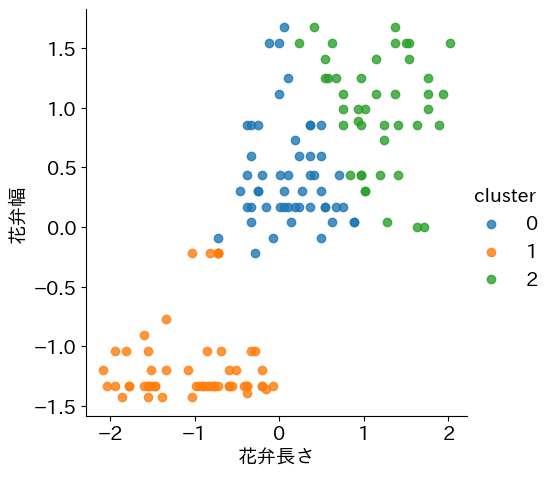

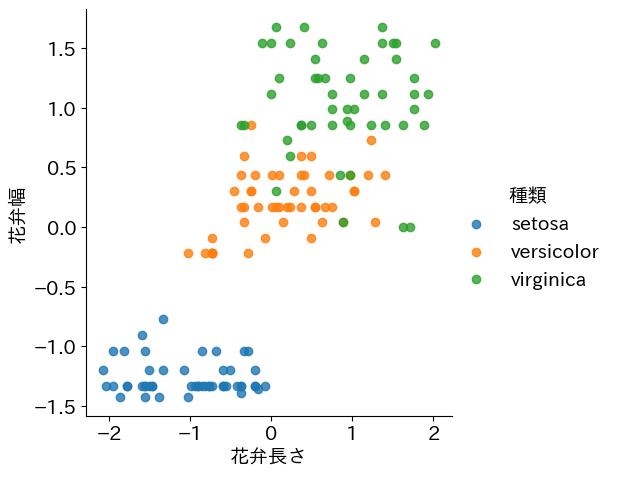

In [64]:
url = 'https://bit.ly/43mPz0L'
df = pd.read_csv(url)
df = df.fillna(df[['がく片長さ', 'がく片幅', '花弁長さ', '花弁幅']].mean())
cols = ['花弁長さ', '花弁幅']
df_cluster = df[cols]
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(df_cluster)
df_s = sc.transform(df_cluster)
df_cluster = pd.DataFrame(df_s, columns = cols)
from sklearn.cluster import KMeans
kmeans_model = KMeans(n_clusters = 3, random_state = random_seed)
kmeans_model.fit(df_cluster)
df_cluster['cluster'] = kmeans_model.labels_
df_cluster['種類'] = df['種類']
sns.lmplot(data = df_cluster, x = '花弁長さ', y = '花弁幅', hue = 'cluster', fit_reg = False)
plt.show()
sns.lmplot(data = df_cluster, x = '花弁長さ', y = '花弁幅', hue = '種類', fit_reg = False)
plt.show()